In [2]:
import torch 
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Linear, ReLU, Sequential
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt
# from torchvision.models import resnet18
from tqdm import tqdm

In [3]:
# DATA_PATH = "/kaggle/input/unibuc-ml-202325/"
DATA_PATH = "../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 1,
    'num_classes': 96,
    'dropout': 0.5,
    'trained_epochs': 0,
    'patience': 5,
    'image_size': (224, 224),
    'best': 0
}

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = pd.read_csv(csv_file)
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return (image, label)    

In [5]:
class TestImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return (image, img_id)


In [6]:
# for more image transforms  https://pytorch.org/vision/stable/transforms.html

# transforms

img_size = hyperparameters['image_size']

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

horizontal_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

vertical_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

gaussian_blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.GaussianBlur(5, sigma=(0.1, 1.0)),
    transforms.ToTensor()
])

translation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

rotation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

color_jitter_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor()
])

resized_crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

extend_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [7]:
# datasets

original_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=original_transform)
horizontal_flip_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=horizontal_flip_transform)
rotation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=rotation_transform)
color_jitter_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=color_jitter_transform)
resized_crop_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=resized_crop_transform)
vertical_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=vertical_flip_transform)
gaussian_blur_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=gaussian_blur_transform)
translation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=translation_transform)
noise_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=noise_transform)
extend_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=extend_transform)

In [8]:
train_dataset = ConcatDataset([original_dataset, horizontal_flip_dataset, rotation_dataset, color_jitter_dataset, resized_crop_dataset, gaussian_blur_dataset, translation_dataset])
val_dataset = CustomImageDataset(img_dir=DATA_PATH + "val_images", csv_file=DATA_PATH + "val.csv", transform=original_transform)
test_dataset = TestImageDataset(img_dir=DATA_PATH + "test_images", csv_file=DATA_PATH + "test.csv", transform=original_transform)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

84000
Original Image


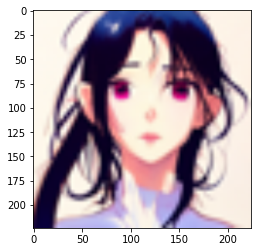

Rotated Image


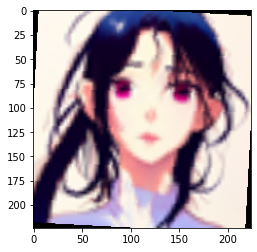

Horizontal Flip Image


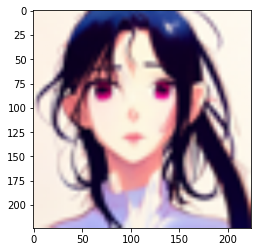

Color Jitter Image


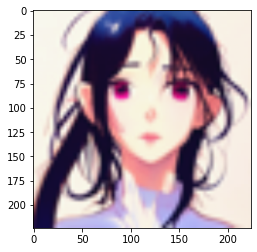

Resized Crop Image


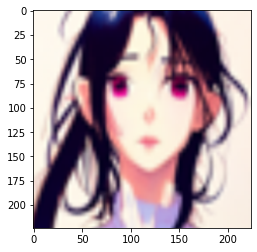

Vertical Flip Image


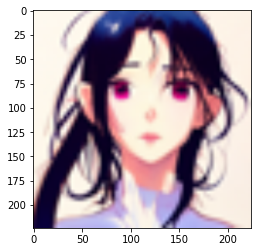

Gaussian Blur Image


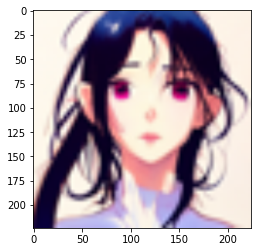

Translation Image


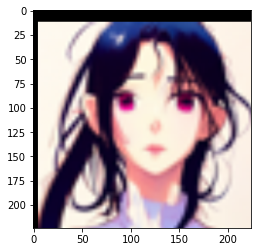

In [9]:
# print image for sanity check

print(len(train_dataset))

print("Original Image")
plt.imshow(original_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Rotated Image")
plt.imshow(rotation_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Horizontal Flip Image")
plt.imshow(horizontal_flip_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Color Jitter Image")
plt.imshow(color_jitter_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Resized Crop Image")
plt.imshow(resized_crop_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Vertical Flip Image")
plt.imshow(vertical_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Gaussian Blur Image")
plt.imshow(gaussian_blur_dataset[0][0].permute(1, 2, 0))
plt.show()

print("Translation Image")
plt.imshow(translation_dataset[0][0].permute(1, 2, 0))
plt.show()



In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)

        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)

        self.activation = nn.ReLU()

        self.shortcut = nn.Sequential()
        if input_channels != output_channels:
            # trick from inception architecture
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, x):
        output = self.activation(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output += self.shortcut(x)
        return self.activation(output)


In [11]:
class ResNet(nn.Module):
    def __init__(self, num_classes=96):
        super(ResNet, self).__init__()

        # resnet works with 224x224 images, you should resize your images before
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.activation = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # architecture for resnet18

        self.layers = nn.Sequential(
            self.make_resnet_layer(ResidualBlock, 64, 64, 2, stride=1),
            self.make_resnet_layer(ResidualBlock, 64, 128, 2, stride=2),
            self.make_resnet_layer(ResidualBlock, 128, 256, 2, stride=2),
            self.make_resnet_layer(ResidualBlock, 256, 512, 2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

    def make_resnet_layer(self, block_type, input_channels, output_channels, num_blocks, stride):
        layers = []
        layers.append(block_type(input_channels, output_channels, stride))
        for i in range(num_blocks - 1):
            layers.append(block_type(output_channels, output_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.activation(self.bn1(self.conv1(x)))
        output = self.maxpool(output)
        output = self.layers(output)
        output = self.avgpool(output)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        return output
        
    

In [12]:
def save_model(model, optimizer, path):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, path)

def load_model(model, optimizer, path):
    state = torch.load(path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    return model, optimizer

In [13]:
def test_model(model, test_loader):
    model.eval()
    predicted_labels = []
    image_ids = []
    with torch.no_grad(): # to disable gradient calculation and backpropagation
        for images, ids in tqdm(test_loader):
            images = images.to(device)

            outputs = model(images) # forward pass

            _, predicted = torch.max(outputs.data, 1) # get the predicted class with highest probability

            predicted_labels.extend(predicted.tolist())
            image_ids.extend(ids)
    return predicted_labels, image_ids

In [20]:
def train_model(train_loader, val_loader, model, optimizer, num_epochs, hyperparameters):
    model = model.to(device)
    criterion = CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=hyperparameters['patience'])
    trained_epochs = hyperparameters['trained_epochs']
#     for epoch in range(num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {trained_epochs + epoch + 1} started... ")
        # set the model to train mode
        # enable dropout, batch normalization etc.
        model.train()
        for images, labels in tqdm(train_loader):
            # loads the images to cuda if available
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute the loss

            optimizer.zero_grad() # reset the gradients because they accumulate by default
            loss.backward() # compute the gradients in the backward pass
            optimizer.step() # update the parameters based on the gradients computed in the backward pass
        print("Validating data...")
        # set the model to evaluation mode
        # disable dropout, batch normalization etc.
        model.eval()
        with torch.no_grad():  #o disable gradient calculation and backpropagation
            val_loss = 0
            correct = 0
            total = 0
            for images, labels in tqdm(val_loader):
                # loads the images to cuda if available
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # torch.max returns a tuple (values, indices) where indices is the index of the maximum value of a tensor along a dimension
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            val_loss /= len(val_loader)
            scheduler.step(val_loss) # step the scheduler based on the validation loss

            print('Epoch [{}/{}], Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
                    .format(trained_epochs + epoch + 1, trained_epochs + num_epochs, 100 * correct / total, val_loss))
            hyperparameters['trained_epochs'] += 1
        if hyperparameters['best'] < correct / total:
            hyperparameters['best'] = correct / total
            save_model(model, optimizer, f"../models/model.pth")
            print("Model saved!")
    return model, optimizer

In [15]:
model = ResNet().to(device)
optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])

In [21]:
model, optimizer = train_model(train_loader, val_loader, model, optimizer, 5, hyperparameters)

Epoch 26 started... 


100%|██████████| 1313/1313 [02:20<00:00,  9.34it/s]


Validating data...


100%|██████████| 16/16 [00:01<00:00, 13.07it/s]


Epoch [26/30], Validation Accuracy: 91.70%, Validation Loss: 0.3298
Epoch 27 started... 


100%|██████████| 1313/1313 [02:21<00:00,  9.30it/s]


Validating data...


100%|██████████| 16/16 [00:01<00:00, 12.88it/s]


Epoch [27/30], Validation Accuracy: 92.30%, Validation Loss: 0.3215
Epoch 28 started... 


100%|██████████| 1313/1313 [02:21<00:00,  9.27it/s]


Validating data...


100%|██████████| 16/16 [00:01<00:00, 13.03it/s]


Epoch [28/30], Validation Accuracy: 91.10%, Validation Loss: 0.3761
Epoch 29 started... 


100%|██████████| 1313/1313 [02:20<00:00,  9.35it/s]


Validating data...


100%|██████████| 16/16 [00:01<00:00, 13.08it/s]


Epoch [29/30], Validation Accuracy: 92.20%, Validation Loss: 0.3487
Epoch 30 started... 


100%|██████████| 1313/1313 [02:20<00:00,  9.38it/s]


Validating data...


100%|██████████| 16/16 [00:01<00:00, 13.02it/s]

Epoch [30/30], Validation Accuracy: 92.00%, Validation Loss: 0.3241


In [25]:
predicted_labels, image_ids = test_model(model, test_loader)

100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


In [24]:
model, optimizer = load_model(model, optimizer, f"model.pth")

In [26]:
df_predictions = pd.DataFrame({
    'Image': image_ids,
    'Class': predicted_labels
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('../submissions/submission_resnet.csv', index=False)